# 제어 가능한 생성자 (Controllable Generator)

### 목표
이 노트북에서는 분류기의 그래디언트를 사용하여 GAN을 제어 가능한 방법을 구현할 것입니다. 관련 특징을 인식하도록 분류기를 훈련하면 생성자의 입력(z-벡터)을 변경하여 해당 특징이 더 많거나 적은 이미지를 생성 할 수 있습니다.

제어 가능성 측면에 집중할 수 있도록 사전 훈련된 생성자 및 분류기로 시작합니다. 그러나 여러분 자신의 분류기를 훈련시키려는 경우를 위해서 해당 코드도 제공됩니다.

### 학습 목표

1. 제어 가능성이 생성자의 출력을 어떻게 변화시킬 수 있는지 관찰하십시오.
2. 얽혀있는 특징들이 제어 가능성에 제기하는 문제 중 일부를 해결합니다.

## 시작하기!

유용한 라이브러리와 패키지를 가져오고 시각화 기능을 정의하는 것으로 시작합니다. 또한 이전 과제에서 생성자, 노이즈 및 감별자 코드가 제공되었습니다. 감별자는 이전 비평가와 동일한 구조를 가지고 있습니다. (감별자/비평가는 단순히 실제와 가짜를 분류하는 데 사용되는 분류기임을 기억하십시오).

#### CelebA

이 노트북의 경우 MNIST 데이터 세트 대신 [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)를 사용합니다. CelebA는 주석이 달린 유명인 이미지의 데이터 세트입니다. 컬러(흑백 아님)이므로 이미지에는 빨강, 녹색 및 파랑 (RGB)에 대한 세 개의 채널이 있습니다.

![celeba](celeba.png)

#### 패키지 및 시각화

In [3]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for our testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=16, size=(3, 64, 64), nrow=3):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

#### Generator and Noise

In [4]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (CelebA is rgb, so 3 is our default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples in the batch, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

#### Classifier

In [5]:
class Classifier(nn.Module):
    '''
    Classifier Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (CelebA is rgb, so 3 is our default)
        n_classes: the total number of classes in the dataset, an integer scalar
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=3, n_classes=2, hidden_dim=64):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            self.make_classifier_block(im_chan, hidden_dim),
            self.make_classifier_block(hidden_dim, hidden_dim * 2),
            self.make_classifier_block(hidden_dim * 2, hidden_dim * 4, stride=3),
            self.make_classifier_block(hidden_dim * 4, n_classes, final_layer=True),
        )

    def make_classifier_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a classifier block; 
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the classifier: Given an image tensor, 
        returns an n_classes-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with im_chan channels
        '''
        class_pred = self.classifier(image)
        return class_pred.view(len(class_pred), -1)

## 매개 변수 지정

학습을 시작하기 전에 몇 가지 매개 변수를 지정해야 합니다.
  * z_dim : 노이즈 벡터의 차원
  * batch_size : 정방향/역방향 패스 당 이미지 수
  * 장치 : 장치 유형

In [6]:
z_dim = 64
batch_size = 128
device = 'cpu'
# device = 'cuda'

## 분류기 훈련 (선택 사항)

이 코드를 사용하여 고유한 분류기를 학습 할 수 있지만 나중에 코드에서 사전 학습 된 분류기가 제공됩니다. 이 코드 블록을 건너 뛰어도 됩니다. 자신 만의 분류기를 훈련 시키려면 처음에 제공된 분류기를 사용하여 과제를 수행하는 것이 좋습니다!

In [25]:
def train_classifier(filename):
    import seaborn as sns
    import matplotlib.pyplot as plt

    # You can run this code to train your own classifier, but there is a provided pretrained one.
    # If you'd like to use this, just run "train_classifier(filename)"
    # to train and save a classifier on the label indices to that filename.

    # Target all the classes, so that's how many the classifier will learn
    label_indices = range(40)

    n_epochs = 3
    display_step = 500
    lr = 0.001
    beta_1 = 0.5
    beta_2 = 0.999
    image_size = 64

    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    dataloader = DataLoader(
        CelebA(".", split='train', download=True, transform=transform),
        batch_size=batch_size,
        shuffle=True)

    classifier = Classifier(n_classes=len(label_indices)).to(device)
    class_opt = torch.optim.Adam(classifier.parameters(), lr=lr, betas=(beta_1, beta_2))
    criterion = nn.BCEWithLogitsLoss()

    cur_step = 0
    classifier_losses = []
    # classifier_val_losses = []
    for epoch in range(n_epochs):
        # Dataloader returns the batches
        for real, labels in tqdm(dataloader):
            real = real.to(device)
            labels = labels[:, label_indices].to(device).float()

            class_opt.zero_grad()
            class_pred = classifier(real)
            class_loss = criterion(class_pred, labels)
            class_loss.backward() # Calculate the gradients
            class_opt.step() # Update the weights
            classifier_losses += [class_loss.item()] # Keep track of the average classifier loss

            ## Visualization code ##
            if cur_step % display_step == 0 and cur_step > 0:
                class_mean = sum(classifier_losses[-display_step:]) / display_step
                print(f"Step {cur_step}: Classifier loss: {class_mean}")
                step_bins = 20
                x_axis = sorted([i * step_bins for i in range(len(classifier_losses) // step_bins)] * step_bins)
                sns.lineplot(x_axis, classifier_losses[:len(x_axis)], label="Classifier Loss")
                plt.legend()
                plt.show()
                torch.save({"classifier": classifier.state_dict()}, filename)
            cur_step += 1

# Uncomment the last line to train your own classfier - this line will not work in Coursera.
# If you'd like to do this, you'll have to download it and run it, ideally using a GPU 
# train_classifier("filename")

## 사전 훈련된 모델 로드
그런 다음 다음 코드를 사용하여 사전 훈련된 생성자와 분류기를 로드합니다. (자신의 분류기를 훈련 한 경우 대신 여기에서 로드 할 수 있습니다.)

In [8]:
import torch
gen = Generator(z_dim).to(device)
gen_dict = torch.load("pretrained_celeba.pth", map_location=torch.device(device))["gen"]
gen.load_state_dict(gen_dict)
gen.eval()

n_classes = 40
classifier = Classifier(n_classes=n_classes).to(device)
class_dict = torch.load("pretrained_classifier.pth", map_location=torch.device(device))["classifier"]
classifier.load_state_dict(class_dict)
classifier.eval()
print("Loaded the models!")

opt = torch.optim.Adam(classifier.parameters(), lr=0.01)

Loaded the models!


## 훈련
이제 GAN을 제어하는 방법을 구현할 수 있습니다!

#### 잡음 업데이트
 
학습을 위해서는 원하는 특징을 더 많이 생성하도록 노이즈를 업데이트하는 코드를 작성해야 합니다. 확률적 경사상승을 수행하여 이를 수행합니다. 로컬 최소값을 찾는 확률적 경사하강법과 반대로, 로컬 최대값을 찾기 위해 확률적 경사상승을 사용합니다. 경사상승은 최적화되는 값의 음수에 대한 경사하강입니다. 그들의 공식은 본질적으로 동일하지만 가중 값을 빼는 대신 확률적 경사상승에서는 이를 더합니다. `new = old + (∇old * weight)`로 계산할 수 있습니다. 여기서 ∇는 `old`의 기울기입니다. 원하는 특징의 양을 최대화하기 위해 확률적 경사상승을 수행합니다. 특징의 양을 줄이려면 경사하강법을 수행합니다. 그러나 이 과제에서는 데이터 세트의 많은 특징이 존재하는 것보다 훨씬 자주 존재하지 않고 이미지에 특징을 추가하는 것이 아니라 제거하려고 하기 때문에 경사상승을 사용하여 특징을 최대화하는 데 관심이 있습니다.

이미 분류기를 통해 계산된 기울기가 있는 노이즈가 주어지면 새 노이즈 벡터를 반환하려고 합니다.

<details>

<summary>
<font size="3" color="green">
<b>Optional hint for <code><font size="4">calculate_updated_noise</font></code></b>
</font>
</summary>

1.   Remember the equation for gradient ascent: `new = old + (∇ old * weight)`.

</details>

In [9]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: calculate_updated_noise
def calculate_updated_noise(noise, weight):
    '''
    Function to return noise vectors updated with stochastic gradient ascent.
    Parameters:
        noise: the current noise vectors. You have already called the backwards function on the target class
          so you can access the gradient of the output class with respect to the noise by using noise.grad
        weight: the scalar amount by which you should weight the noise gradient
    '''
    #### START CODE HERE ####
    new_noise = noise + ( noise.grad * weight)    
    #### END CODE HERE ####
    return new_noise

In [10]:
# UNIT TEST
# Check that the basic function works
opt.zero_grad()
noise = torch.ones(20, 20) * 2
noise.requires_grad_()
fake_classes = (noise ** 2).mean()
fake_classes.backward()
new_noise = calculate_updated_noise(noise, 0.1)
assert type(new_noise) == torch.Tensor
assert tuple(new_noise.shape) == (20, 20)
assert new_noise.max() == 2.0010
assert new_noise.min() == 2.0010
assert torch.isclose(new_noise.sum(), torch.tensor(0.4) + 20 * 20 * 2)
print("Success!")

Success!


In [11]:
# Check that it works for generated images
opt.zero_grad()
noise = get_noise(32, z_dim).to(device).requires_grad_()
fake = gen(noise)
fake_classes = classifier(fake)[:, 0]
fake_classes.mean().backward()
noise.data = calculate_updated_noise(noise, 0.01)
fake = gen(noise)
fake_classes_new = classifier(fake)[:, 0]
assert torch.all(fake_classes_new > fake_classes)
print("Success!")

Success!


#### 생성자

이제 확률적 경사상승과 함께 분류기를 사용하여 특정 특징을 더 많이 생성하는 노이즈를 만들 수 있습니다. 여기에 제공된 코드에서 웃는 얼굴을 생성 할 수 있습니다. 대상 색인을 자유롭게 변경하고 목록의 다른 특징을 제어하십시오! 일부 특징은 다른 특징보다 감지하고 제어하기가 더 쉽습니다.

여기에 있는 목록은 분류기를 훈련하는 데 사용했던 CelebA에 표시된 특징입니다. 다른 특징을 제어하려면 해당 특징으로 레이블이 지정된 데이터를 가져와서 해당 특징에 대한 분류기를 훈련해야 합니다.

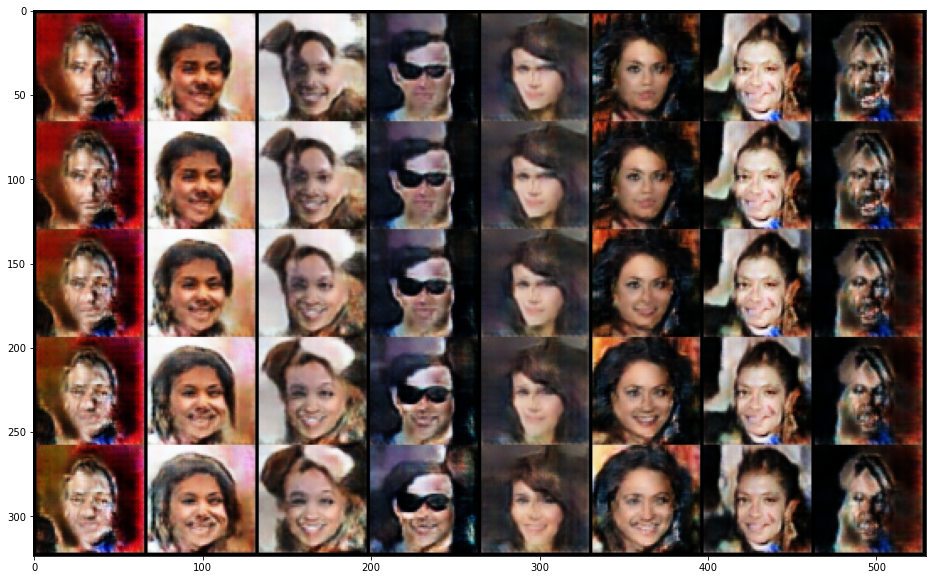

In [12]:
# First generate a bunch of images with the generator
n_images = 8
fake_image_history = []
grad_steps = 10 # Number of gradient steps to take
skip = 2 # Number of gradient steps to skip in the visualization

feature_names = ["5oClockShadow", "ArchedEyebrows", "Attractive", "BagsUnderEyes", "Bald", "Bangs",
"BigLips", "BigNose", "BlackHair", "BlondHair", "Blurry", "BrownHair", "BushyEyebrows", "Chubby",
"DoubleChin", "Eyeglasses", "Goatee", "GrayHair", "HeavyMakeup", "HighCheekbones", "Male", 
"MouthSlightlyOpen", "Mustache", "NarrowEyes", "NoBeard", "OvalFace", "PaleSkin", "PointyNose", 
"RecedingHairline", "RosyCheeks", "Sideburn", "Smiling", "StraightHair", "WavyHair", "WearingEarrings", 
"WearingHat", "WearingLipstick", "WearingNecklace", "WearingNecktie", "Young"]

### Change me! ###
target_indices = feature_names.index("Smiling") # Feel free to change this value to any string from feature_names!

noise = get_noise(n_images, z_dim).to(device).requires_grad_()
for i in range(grad_steps):
    opt.zero_grad()
    fake = gen(noise)
    fake_image_history += [fake]
    fake_classes_score = classifier(fake)[:, target_indices].mean()
    fake_classes_score.backward()
    noise.data = calculate_updated_noise(noise, 1 / grad_steps)

plt.rcParams['figure.figsize'] = [n_images * 2, grad_steps * 2]
show_tensor_images(torch.cat(fake_image_history[::skip], dim=2), num_images=n_images, nrow=n_images)

## 얽힘 및 정규화

또한 대상 특징보다 더 많은 특징이 변경되는 경우도 있습니다. 일부 특징이 얽혀 있기 때문입니다. 이 문제를 해결하려면 대상 클래스 상수 외부의 클래스를 유지하여 대상 특징을 더 격리하려고 시도 할 수 있습니다. 이를 구현할 수 있는 한 가지 방법은 L2 정규화를 사용하여 원래 클래스와의 차이점에 페널티를 주는 것입니다. 이 L2 정규화는 L2 norm을 사용하여 이 차이에 대한 페널티를 적용하며 이는 손실 함수에 대한 추가 항 일뿐입니다.

여기서 점수 함수를 구현해야 합니다. 높을수록 좋습니다. 점수는 목표 점수와 페널티를 더하여 계산됩니다. 페널티는 점수를 낮추기 위한 것이므로 음수 값을 가져야 합니다.

대상이 아닌 모든 클래스에 대해 현재 노이즈와 이전 노이즈의 차이를 확인합니다. 이 값이 클수록 대상 외부의 특징이 더 많이 변경되었습니다. 변화의 크기를 계산하고 평균을 취하고 부정합니다. 마지막으로이 패널티를 목표 점수에 추가합니다. 목표 점수는 현재 소음에서 목표 등급의 평균입니다.

<details>

<summary>
<font size="3" color="green">
<b>Optional hints for <code><font size="4">get_score</font></code></b>
</font>
</summary>

1. 점수가 높을수록 좋습니다!
2. 이미지 당 손실을 계산하려고 하므로 [`torch.norm`](https://pytorch.org/docs/stable/generated/torch.norm.html)에 dim 인수를 전달해야 합니다. .
3. 변화의 크기를 계산하려면 규범의 차이가 아니라 분류 간의 차이에 대한 규범을 취해야 합니다.

</details>

In [15]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_score
def get_score(current_classifications, original_classifications, target_indices, other_indices, penalty_weight):
    '''
    Function to return the score of the current classifications, penalizing changes
    to other classes with an L2 norm.
    Parameters:
        current_classifications: the classifications associated with the current noise
        original_classifications: the classifications associated with the original noise
        target_indices: the index of the target class
        other_indices: the indices of the other classes
        penalty_weight: the amount that the penalty should be weighted in the overall score
    '''
    # Steps: 1) Calculate the change between the original and current classifications (as a tensor)
    #           by indexing into the other_indices you're trying to preserve, like in x[:, features].
    #        2) Calculate the norm (magnitude) of changes per example.
    #        3) Multiply the mean of the example norms by the penalty weight. 
    #           This will be your other_class_penalty.
    #           Make sure to negate the value since it's a penalty!
    #        4) Take the mean of the current classifications for the target feature over all the examples.
    #           This mean will be your target_score.
    #### START CODE HERE ####
    other_distances = current_classifications[:,other_indices] - original_classifications[:,other_indices]
    # Calculate the norm (magnitude) of changes per example and multiply by penalty weight
    other_class_penalty = -torch.norm(other_distances, dim=1).mean() * penalty_weight
    # Take the mean of the current classifications for the target feature
    target_score = current_classifications[:, target_indices].mean()
    #### END CODE HERE ####
    return target_score + other_class_penalty

In [16]:
# UNIT TEST
assert torch.isclose(
    get_score(torch.ones(4, 3), torch.zeros(4, 3), [0], [1, 2], 0.2), 
    1 - torch.sqrt(torch.tensor(2.)) * 0.2
)
rows = 10
current_class = torch.tensor([[1] * rows, [2] * rows, [3] * rows, [4] * rows]).T.float()
original_class = torch.tensor([[1] * rows, [2] * rows, [3] * rows, [4] * rows]).T.float()

# Must be 3
assert get_score(current_class, original_class, [1, 3] , [0, 2], 0.2).item() == 3

current_class = torch.tensor([[1] * rows, [2] * rows, [3] * rows, [4] * rows]).T.float()
original_class = torch.tensor([[4] * rows, [4] * rows, [2] * rows, [1] * rows]).T.float()

# Must be 3 - 0.2 * sqrt(10)
assert torch.isclose(get_score(current_class, original_class, [1, 3] , [0, 2], 0.2), 
                     -torch.sqrt(torch.tensor(10.0)) * 0.2 + 3)

print("Success!")

Success!


다음 코드 블록에서는 이 새로운 점수 함수를 사용하여 경사 상승을 실행합니다. 실행 후 몇 가지 사항을 알 수 있습니다.

1. 원래 접근 방식과 비교할 때 대상 기능을 생성하는 데 더 자주 실패 할 수 있습니다. 이는 모델이 다른 기능을 변경하지 않고는 대상 특징이 있는 이미지를 생성 할 수 없음을 의미합니다. 말이 되네요! 예를 들어, 웃고 있지만 입이 약간 열려 있지 않은 얼굴을 생성하지 못할 수 있습니다. 이것은 또한 생성기의 한계를 노출시킬 수 있습니다. 또는 생성기가 의도한 특징으로 이미지를 생성 할 수 있더라도 거기에 도달하기 위해 많은 중간 변경이 필요할 수 있으며 로컬 최소값에 갇힐 수 있습니다.

2. 이 과정은 이 방법으로 페널티를 줄 방법이 없기 때문에 분류자가 인식하도록 훈련되지 않은 특징을 변경할 수 있습니다. 감독되지 않은 특징의 변경을 방지하기 위해 모델을 훈련시킬 수 있는지 여부는 열린 질문입니다.

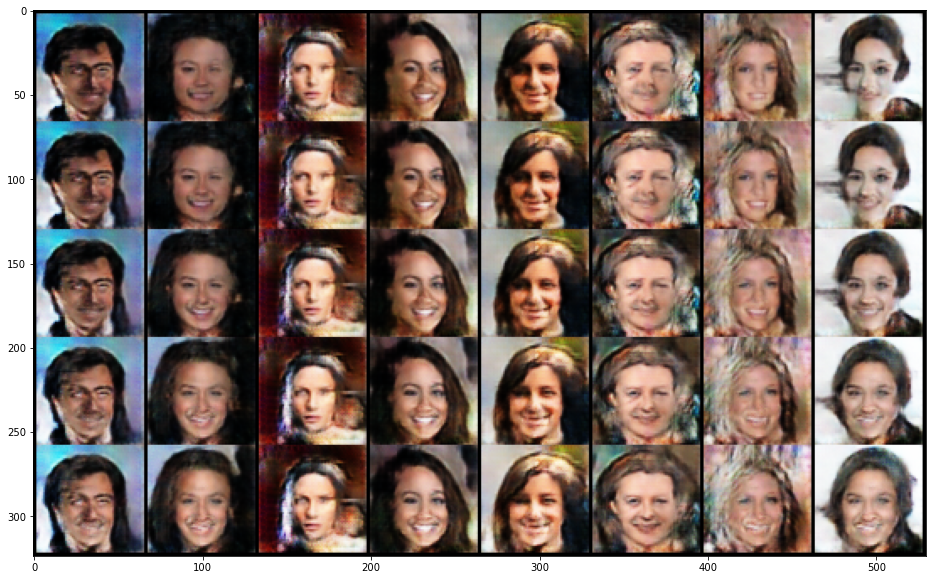

In [17]:
fake_image_history = []
### Change me! ###
target_indices = feature_names.index("Smiling") # Feel free to change this value to any string from feature_names from earlier!
other_indices = [cur_idx != target_indices for cur_idx, _ in enumerate(feature_names)]
noise = get_noise(n_images, z_dim).to(device).requires_grad_()
original_classifications = classifier(gen(noise)).detach()
for i in range(grad_steps):
    opt.zero_grad()
    fake = gen(noise)
    fake_image_history += [fake]
    fake_score = get_score(
        classifier(fake), 
        original_classifications,
        target_indices,
        other_indices,
        penalty_weight=0.1
    )
    fake_score.backward()
    noise.data = calculate_updated_noise(noise, 1 / grad_steps)

plt.rcParams['figure.figsize'] = [n_images * 2, grad_steps * 2]
show_tensor_images(torch.cat(fake_image_history[::skip], dim=2), num_images=n_images, nrow=n_images)